This is for importing all the important libraries required for the script.

In [89]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image

import the data, if data is a video, extract frames into temp_frames folder

In [90]:
dataset_path = "nightime-ir/Fire/Raw JPG"

if os.path.exists("temp_frames"):
        shutil.rmtree("temp_frames")

if dataset_path.endswith((".mp4", ".avi", ".mov")):
    os.makedirs("temp_frames")
    cap = cv2.VideoCapture(dataset_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break 

        frame_filename = os.path.join("temp_frames", f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1
    cap.release()
    image_folder="temp_frames"  
else:
    image_folder = dataset_path 
    fps=6

label_folder = os.path.join(dataset_path, "labels")

CHECK LOGBOOK FOR BANGER IDEA

In [91]:
filenames = sorted(os.listdir(image_folder))

first_image = cv2.imread(os.path.join(image_folder, filenames[0]))
if first_image is None:
    raise ValueError("Error: Could not read the first image.")

height, width = first_image.shape[:2]  

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
out = cv2.VideoWriter("fire_detection.mp4", fourcc, fps, (width, height))

if not out.isOpened():
    raise ValueError("⚠ Error: VideoWriter failed to initialize.")

detected = 0

for filename in filenames:
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path) 
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # L,A,B=cv2.split(mask)
    L=mask[:,:,0]
    A=mask[:,:,1]
    B=mask[:,:,2]
    # L_lower, L_upper = 100.57, 204.50
    # A_lower, A_upper = 139.53, 184.07
    # B_lower, B_upper = 180.01, 201.76
    L_lower, L_upper = 100, 255 
    A_lower, A_upper = 0, 128 # best for detection is 0,128
    B_lower, B_upper = 0, 128

    actual_label = None  
    # if actual_labels_available:
    #     label_path = os.path.join(label_folder, filename.replace('.jpg', '.txt'))
    #     if os.path.exists(label_path):
    #         with open(label_path, 'r') as f:
    #             label_content = f.read().strip()
    #             actual_label = int(label_content) if label_content.isdigit() else 0

    L_mask = (L >= L_lower) & (L <= L_upper)
    A_mask = (A >= A_lower) & (A <= A_upper)
    B_mask = (B >= B_lower) & (B <= B_upper)

    fire_mask=L_mask & A_mask & B_mask
    fire_mask=fire_mask.astype(np.uint8)*255
    # kernel = np.ones((5, 5), np.uint8)
    
    # fire_mask=cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel)
    # fire_mask = cv2.morphologyEx(fire_mask, cv2.MORPH_CLOSE, kernel)
    colored_fire=np.zeros_like(img)
    colored_fire[fire_mask ==255]=img[fire_mask==255]

    contours, _ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) > 50:  
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
            detected += 1   

    out.write(img)  
     

out.release()

In [92]:
max_value=np.min(L)
max_value

np.uint8(0)

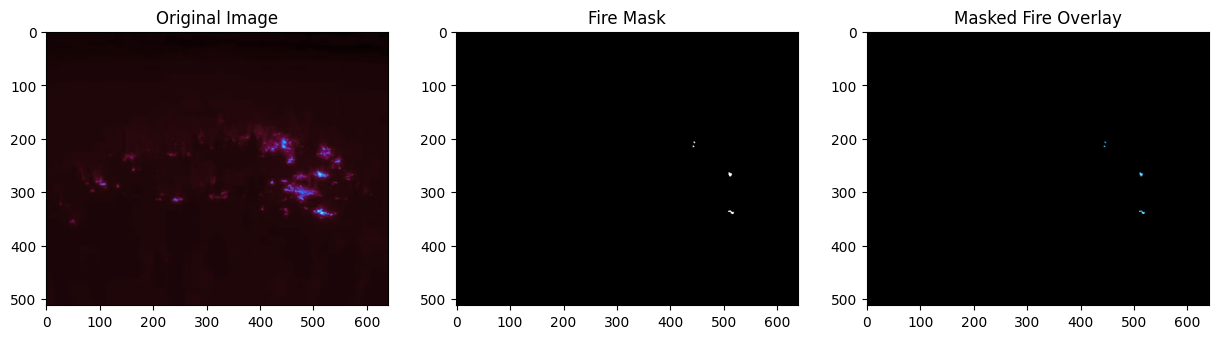

In [93]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(fire_mask, cmap="gray")
plt.title("Fire Mask")

plt.subplot(1, 3, 3)
plt.imshow(colored_fire)
plt.title("Masked Fire Overlay")

plt.show()

In [94]:
if actual_labels_available:
        valid_comparisons = [x for x in computed_labels if x[2] is not None]  
        correct = sum(1 for _, c, a in valid_comparisons if c == a)
        accuracy = correct / len(valid_comparisons) * 100 if valid_comparisons else 0
        print(f'✅ Accuracy: {accuracy:.2f}%')
else:
    print("⚠ No labels found. Skipping accuracy evaluation.")

if os.path.exists("temp_frames"):
        shutil.rmtree("temp_frames")

NameError: name 'actual_labels_available' is not defined